In [16]:
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

%matplotlib notebook
sns.set(style="whitegrid")

In [2]:
# load data
gdoc_url = 'https://docs.google.com/spreadsheets/d/1X1HTxkI6SqsdpNSkSSivMzpxNT-oeTbjFFDdEkXD30o/export?format=csv&id=1X1HTxkI6SqsdpNSkSSivMzpxNT-oeTbjFFDdEkXD30o&gid=695409533'
r = requests.get(gdoc_url)
data = r.content
df = pd.read_csv(BytesIO(data), index_col=None, header=0)

In [3]:
#preprocess data
df['Reviewer Rating'] = pd.to_numeric(df['Reviewer Rating'], errors='coerce')
df = df[['Whisky Name','Reviewer Rating', 'Whisky Region or Style','Link To Reddit Review']]
# df = df.dropna()

#homogenize region names
df['Whisky Region or Style'] = df['Whisky Region or Style'].str.lower()
df['Whisky Region or Style'] = df['Whisky Region or Style'].str.rstrip('s')

# only consider a 0-100 system, hopefully
df = df[df['Reviewer Rating'] > 40]

# By Region

In [4]:
df_region = df.groupby('Whisky Region or Style').filter(lambda x: len(x) > 50)
df_region

Whisky Name  Reviewer Rating  \
0                                        100 Pipers             68.0   
2                           1792 225th Anniversary              80.0   
3                              1792 Bottled In Bond             80.0   
4      1792 Bottled In Bond Oak Liquor Cabinet Pick             90.0   
5                                   1792 Full Proof             85.0   
...                                             ...              ...   
33226                      Ardbeg Lord of the Isles             91.0   
33227                     Glendronach 18 Tawny Port             70.0   
33228                 Mortlach 22 Marriage of Casks             90.0   
33229                 Barrell Bourbon New Year 2017             84.0   
33230                               Auchentoshan 21             85.0   

      Whisky Region or Style  \
0                      blend   
2                    bourbon   
3                    bourbon   
4                    bourbon   
5                    bourbon   
...                      ...   
33226                  islay   
33227               speyside   
33228               speyside   
33229                bourbon   
33230                lowland   

                                   Link To Reddit Review  
0      http://www.reddit.com/r/Scotch/comments/14uder...  
2      https://www.reddit.com/r/bourbon/comments/7445...  
3      https://www.reddit.com/r/bourbon/comments/9ryi...  
4      https://www.reddit.com/r/bourbon/comments/a7jw...  
5      https://www.reddit.com/r/bourbon/comments/5aez...  
...                                                  ...  
33226  https://www.reddit.com/r/Scotch/comments/eib00...  
33227  https://www.reddit.com/r/Scotch/comments/eiixp...  
33228  https://www.reddit.com/r/Scotch/comments/eij5h...  
33229  https://www.reddit.com/r/bourbon/comments/eiqj...  
33230  https://www.reddit.com/r/Scotch/comments/eis6x...  

[31925 rows x 4 columns]

In [5]:
sort = df_region.groupby('Whisky Region or Style').aggregate([np.count_nonzero,np.median]).sort_values(by=('Reviewer Rating','median'))
order = sort.index[::-1]
count = sort[('Reviewer Rating','count_nonzero')].values[::-1]

[Text(0, 0, 'australia\nN = 167'),
 Text(0, 1, 'islay\nN = 6010'),
 Text(0, 2, 'india\nN = 317'),
 Text(0, 3, 'rye\nN = 1334'),
 Text(0, 4, 'campbeltown\nN = 1037'),
 Text(0, 5, 'sweden\nN = 56'),
 Text(0, 6, 'speyside\nN = 6513'),
 Text(0, 7, 'island\nN = 2104'),
 Text(0, 8, 'taiwan\nN = 169'),
 Text(0, 9, 'bourbon\nN = 5679'),
 Text(0, 10, 'highland\nN = 3644'),
 Text(0, 11, 'lowland\nN = 486'),
 Text(0, 12, 'japan\nN = 548'),
 Text(0, 13, 'grain\nN = 65'),
 Text(0, 14, 'france\nN = 54'),
 Text(0, 15, 'blend\nN = 1793'),
 Text(0, 16, 'america\nN = 545'),
 Text(0, 17, 'canada\nN = 682'),
 Text(0, 18, 'ireland\nN = 652'),
 Text(0, 19, 'wheat\nN = 70')]

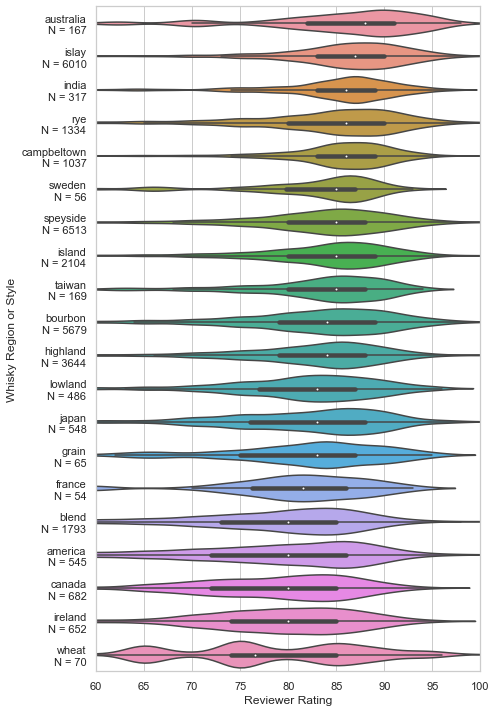

In [6]:
plt.figure(figsize=(7,10))
ax = sns.violinplot(y='Whisky Region or Style', x='Reviewer Rating', data=df_region, order=order, scale='width', bw=0.2)
ax.set_xlim(60,100)
# ax.tick_params(axis='y',labelrotation=45)
plt.tight_layout()

for i, label in enumerate(ax.get_yticklabels()):
    label.set_text(order[i] + '\n' + 'N = ' +  str(int(count[i])))
ax.set_yticklabels(ax.get_yticklabels())

In [7]:
# is australia significantly better than islay?
from scipy.stats import ks_2samp

In [8]:
aus = df[df['Whisky Region or Style'] == 'australia']['Reviewer Rating']
isl = df[df['Whisky Region or Style'] == 'islay']['Reviewer Rating']

In [9]:
ks_2samp(aus, isl, 'greater')

Ks_2sampResult(statistic=0.07300507138800602, pvalue=0.1683025710733712)

# By Whisky

In [189]:
#extract first three words
df_whisky = df.copy()
df_whisky.loc[:,'Whisky Name'] = df_whisky['Whisky Name'].str.extract('([^\ ]+[\ ]*[^\ ]*[\ ]*[^\ ]*)',expand=False)
df_whisky = df_whisky.groupby('Whisky Name').filter(lambda x: len(x) > 20)
df_whisky

Whisky Name  Reviewer Rating Whisky Region or Style  \
5             1792 Full Proof             85.0                bourbon   
6             1792 Full Proof             69.0                bourbon   
7             1792 Full Proof             85.0                bourbon   
8             1792 Full Proof             78.0                bourbon   
9             1792 Full Proof             87.0                bourbon   
...                       ...              ...                    ...   
33166    William Larue Weller            100.0                bourbon   
33167           Eagle Rare 17             90.0                bourbon   
33185  Laphroaig Quarter Cask             66.0                  islay   
33208         Wild Turkey 101             70.0                bourbon   
33214           Springbank 15             90.0            campbeltown   

                                   Link To Reddit Review  
5      https://www.reddit.com/r/bourbon/comments/5aez...  
6      https://www.reddit.com/r/bourbon/comments/6epe...  
7      https://www.reddit.com/r/bourbon/comments/6ijt...  
8      https://www.reddit.com/r/bourbon/comments/6kax...  
9      https://www.reddit.com/r/bourbon/comments/56f1...  
...                                                  ...  
33166  https://www.reddit.com/r/bourbon/comments/edsj...  
33167  https://www.reddit.com/r/bourbon/comments/edsj...  
33185  https://www.reddit.com/r/Scotch/comments/eg267...  
33208  https://www.reddit.com/r/bourbon/comments/ehwb...  
33214  https://www.reddit.com/r/Scotch/comments/ei92n...  

[15048 rows x 4 columns]

In [193]:
#how many whiskies

n = 25

sort = df_whisky.groupby('Whisky Name').aggregate([np.count_nonzero,np.median]).sort_values(by=('Reviewer Rating','median')).tail(n)
order = sort.index[::-1]
count = sort[('Reviewer Rating','count_nonzero')].values[::-1]

<IPython.core.display.Javascript object>


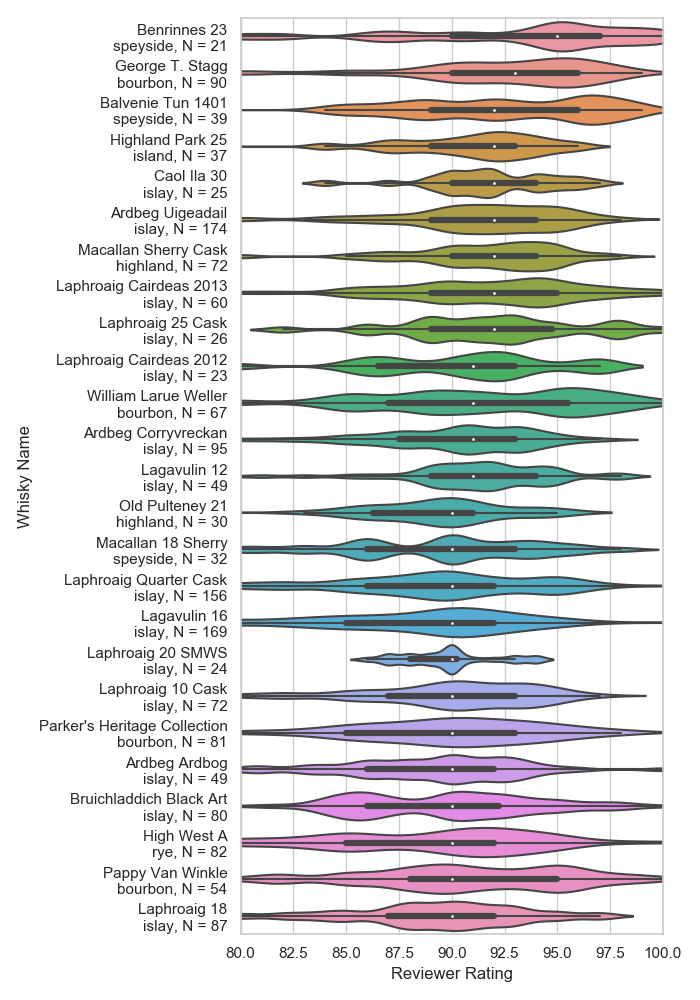

[Text(0, 0, 'Benrinnes 23\nspeyside, N = 21'),
 Text(0, 1, 'George T. Stagg\nbourbon, N = 90'),
 Text(0, 2, 'Balvenie Tun 1401\nspeyside, N = 39'),
 Text(0, 3, 'Highland Park 25\nisland, N = 37'),
 Text(0, 4, 'Caol Ila 30\nislay, N = 25'),
 Text(0, 5, 'Ardbeg Uigeadail\nislay, N = 174'),
 Text(0, 6, 'Macallan Sherry Cask\nhighland, N = 72'),
 Text(0, 7, 'Laphroaig Cairdeas 2013\nislay, N = 60'),
 Text(0, 8, 'Laphroaig 25 Cask\nislay, N = 26'),
 Text(0, 9, 'Laphroaig Cairdeas 2012\nislay, N = 23'),
 Text(0, 10, 'William Larue Weller\nbourbon, N = 67'),
 Text(0, 11, 'Ardbeg Corryvreckan\nislay, N = 95'),
 Text(0, 12, 'Lagavulin 12\nislay, N = 49'),
 Text(0, 13, 'Old Pulteney 21\nhighland, N = 30'),
 Text(0, 14, 'Macallan 18 Sherry\nspeyside, N = 32'),
 Text(0, 15, 'Laphroaig Quarter Cask\nislay, N = 156'),
 Text(0, 16, 'Lagavulin 16\nislay, N = 169'),
 Text(0, 17, 'Laphroaig 20 SMWS\nislay, N = 24'),
 Text(0, 18, 'Laphroaig 10 Cask\nislay, N = 72'),
 Text(0, 19, "Parker's Heritage Collec

In [194]:
plt.figure(figsize=(7,10))
ax = sns.violinplot(y='Whisky Name', x='Reviewer Rating', data=df_whisky, order=order, scale='width', bw=0.18)
ax.set_xlim(80,100)
# ax.tick_params(axis='y',labelrotation=45)
plt.tight_layout()

for i, label in enumerate(ax.get_yticklabels()):
    region = df_whisky[df_whisky['Whisky Name'] == label.get_text()].iloc[0,2]
    label.set_text(order[i] + '\n' + region + ', N = ' +  str(int(count[i])))
ax.set_yticklabels(ax.get_yticklabels())

# By both

In [13]:
#extract first three words
region = 'islay'

df_whisky = df.copy()
df_whisky = df_whisky[df_whisky['Whisky Region or Style'] == region]
df_whisky.loc[:,'Whisky Name'] = df_whisky['Whisky Name'].str.extract('([^\ ]+[\ ]*[^\ ]*[\ ]*[^\ ]*)',expand=False)
df_whisky = df_whisky.groupby('Whisky Name').filter(lambda x: len(x) > 10)

In [14]:
#how many whiskies

n = 20

sort = df_whisky.groupby(df_whisky['Whisky Name'].str.extract('([^\ ]+[\ ]*[^\ ]*[\ ]*[^\ ]*)',expand=False)).aggregate([np.count_nonzero,np.median]).sort_values(by=('Reviewer Rating','median')).tail(n)
order = sort.index[::-1]
count = sort[('Reviewer Rating','count_nonzero')].values[::-1]

[Text(0, 0, 'Bruichladdich Octomore 2.2\nislay, N = 11'),
 Text(0, 1, 'Laphroaig Cairdeas 2013\nislay, N = 60'),
 Text(0, 2, 'Caol Ila 30\nislay, N = 25'),
 Text(0, 3, 'Ardbeg Uigeadail\nislay, N = 173'),
 Text(0, 4, 'Laphroaig 25 Cask\nislay, N = 26'),
 Text(0, 5, 'Lagavulin 12\nislay, N = 49'),
 Text(0, 6, 'Lagavulin 1997 Distillers\nislay, N = 11'),
 Text(0, 7, 'Lagavulin Feis Ile\nislay, N = 12'),
 Text(0, 8, 'Laphroaig Cairdeas 2012\nislay, N = 23'),
 Text(0, 9, 'Laphroaig 14 1998\nislay, N = 11'),
 Text(0, 10, 'Ardbeg Corryvreckan\nislay, N = 95'),
 Text(0, 11, 'Ardbeg Day\nislay, N = 12'),
 Text(0, 12, 'Lagavulin 12 \nislay, N = 16'),
 Text(0, 13, 'Kilchoman 5 Single\nislay, N = 14'),
 Text(0, 14, 'Laphroaig Quarter Cask\nislay, N = 156'),
 Text(0, 15, 'Laphroaig 10 Cask\nislay, N = 72'),
 Text(0, 16, 'Lagavulin 16\nislay, N = 169'),
 Text(0, 17, 'Ardbeg Supernova 2014\nislay, N = 11'),
 Text(0, 18, 'Bruichladdich Octomore 4.2_167\nislay, N = 19'),
 Text(0, 19, 'Caol Ila Feis\ni

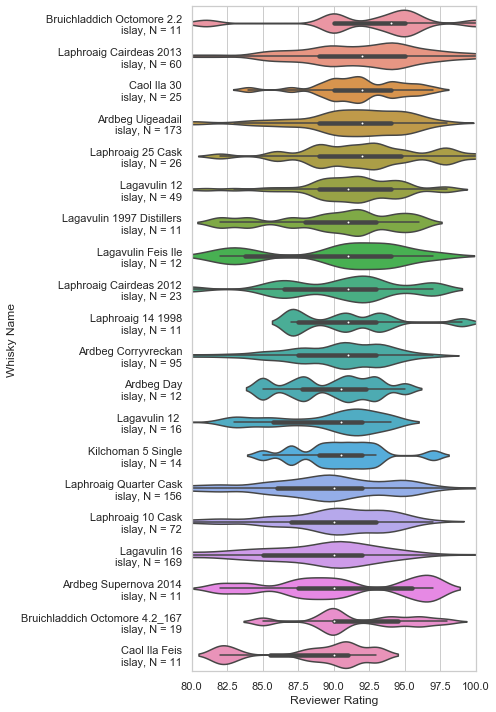

In [15]:
plt.figure(figsize=(7,10))
ax = sns.violinplot(y='Whisky Name', x='Reviewer Rating', data=df_whisky, order=order, scale='width', bw=0.18)
ax.set_xlim(80,100)
# ax.tick_params(axis='y',labelrotation=45)
plt.tight_layout()

for i, label in enumerate(ax.get_yticklabels()):
    region = df_whisky[df_whisky['Whisky Name'] == label.get_text()].iloc[0,2]
    label.set_text(order[i] + '\n' + region + ', N = ' +  str(int(count[i])))
ax.set_yticklabels(ax.get_yticklabels())

# Reddit scraping

In [183]:
def get_json(review_url):
    if re.search('reddit.com', review_url) == None:
        print(review_url+  ' is not a reddit link.')
        raise Exception(review_url+  ' is not a reddit link.')
    try:
        r = requests.get(review_url + '/.json', headers = {'User-agent': 'fxv1'})
        data = r.json()
        return data
    except:
        pass
    try: 
        r = requests.get(review_url[:review_url.rfind('/')] + '/.json', headers = {'User-agent': 'fxv1'})
        data = r.json()
        return data
    except:
        print(review_url+  ' is broken.')
        raise Exception(review_url+  ' is broken.')
def get_review(data):
    """Janky json code"""
    # if it's not a self-post AND it's not a community review thread, get the main post url links to
    if (data[0]['data']['children'][0]['data']['is_self'] == False) and (re.search('Community', data[0]['data']['children'][0]['data']['title'], flags=re.IGNORECASE) == None):
        review = {data[1]['data']['children'][0]['data']['body']}
    # if it's a community review thread, get each comment
    # usually it's directly linked, so this only gets the linked comment?
    elif re.search('Community', data[0]['data']['children'][0]['data']['title'], flags=re.IGNORECASE) != None:
        review_temp = set()
        for i in range(len(data[1]['data']['children'])):
            review_temp.update({data[1]['data']['children'][i]['data']['body']})
        review = review_temp
    # else (if it's a self-post), get the main post
    else:
        review = {data[0]['data']['children'][0]['data']['selftext']}
    return review

## By region

In [184]:
# by region, use sets for uniqueness of reviews
review_txt = set()

region = 'australia'

for review_url in df_region[df_region['Whisky Region or Style'] == region].iloc[:,3]:
    try:
        data = get_json(review_url)
        review_txt.update(get_review(data))
#         print(review_txt)
    except:
        continue
        
#convert to string
review_txt = ''.join(review_txt)

In [186]:
remove_words = ['note', 'finish', 'color', 'colour', 'nose', 'palate', 'taste', 'really', 'whisky', 'review', 'edit', 'price', 'rating', 'deleted']
for word in remove_words:
    review_txt = re.sub(word, '', review_txt, flags=re.IGNORECASE)

In [187]:
wordcloud = WordCloud(background_color='white').generate(review_txt)

<IPython.core.display.Javascript object>


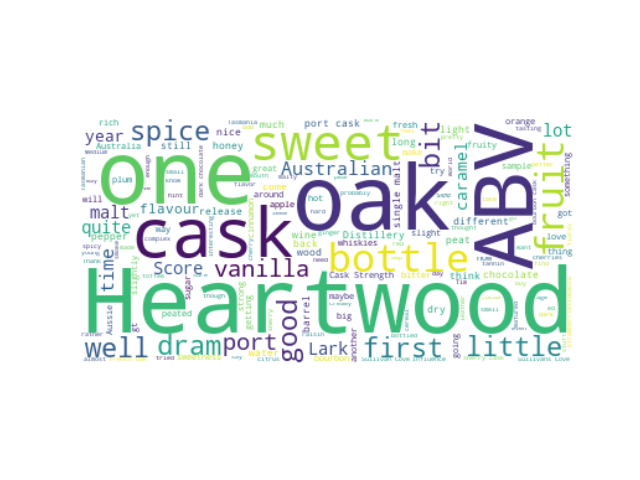

(-0.5, 399.5, 199.5, -0.5)

In [188]:
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

## By whisky

In [210]:
# by region, use sets for uniqueness of reviews
review_txt = set()

# whisky = sort.iloc[-1].name
whisky = sort.index

for review_url in df_whisky[np.isin(df_whisky['Whisky Name'],whisky)].iloc[:,3]:
    try:
        data = get_json(review_url)
        review_txt.update(get_review(data))
    except:
        continue

#convert to string
review_txt = ''.join(review_txt)

https://c2.staticflickr.com/8/7059/6905284987_3f403fd242_b.jpg is not a reddit link.
https://redd.it/3nia4f is not a reddit link.
www.reddit.com/r/Scotch/comments/2pe47u/review_6_lagavulin_16/ is broken.
http://redd.it/2pmc8c is not a reddit link.
www.reddit.com/r/Scotch/comments/q9c0u/review_the_macallan_cask_strength/ is broken.
https://redd.it/3nwtdn is not a reddit link.


In [214]:
review_txt

'I\'ll wrap up my reviews of Buffalo Trace\'s wheated bourbons (for now at least) with **William Larue Weller 2010**. This bottle was my first foray into the BTAC. It is bottled at 63.3% abv. It is also the only bottle of WLW that I\'ve seen in the wild.\n\n* **Color:** Dark Amber.\n\n* **Nose:** As expected, at 63.3%, there is a good amount of alcohol on the nose. I did, however, find notes of oak, vanilla, dried fruits, and caramel.\n\n* **Taste:** Full-bodied, buttery mouthfeel. The palate is full of vanilla, caramel, oak, dried fruits, dark chocolate, and cinnamon. Surprisingly, there was very little alcohol here. \n\n* **Finish:** Even at full proof, I didn\'t find the finish to be overly harsh. There is alcohol present, but that\'s to be expected. However, while very warming, I never found the finish to turn hot. The oak from the nose and the palate fades and you\'re left with a lot of vanilla and caramel, very nice.\n\n&gt; **95/100**\n\nOne thing I would point out is that I bel

In [205]:
remove_words = ['note', 'finish', 'color', 'colour', 'nose', 'palate', 'taste', 'really', 'whisky', 'review', 'edit', 'price', 'rating', 'deleted']
for word in remove_words:
    review_txt = re.sub(word, '', review_txt, flags=re.IGNORECASE)

In [206]:
wordcloud = WordCloud(background_color='white').generate(review_txt)

<IPython.core.display.Javascript object>


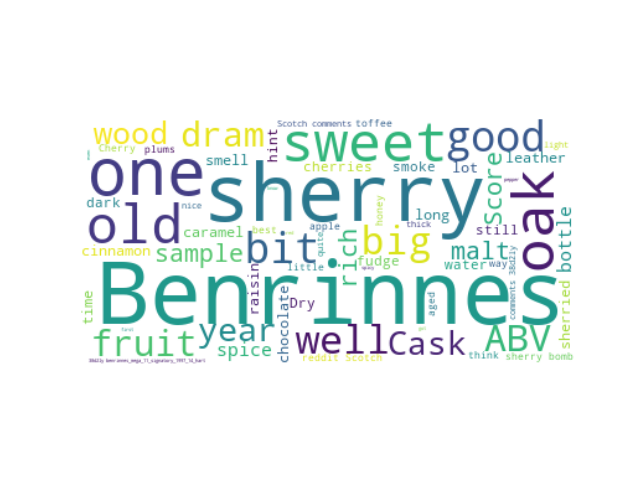

(-0.5, 399.5, 199.5, -0.5)

In [207]:
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Sandbox

In [176]:
df.iloc[0,3]

'http://www.reddit.com/r/Scotch/comments/14uder/100_pipers_blend_review_10/c7ghjy2'

In [241]:
get_review(df.iloc[0,3])

"My wife and I are on a trip to Thailand to meet her family.  I've seen plenty of whisky here, mostly JW, but this one stood out from the rest.  100 pipers is not something I've seen before and it seems to have quite the following here.  It is a blend at 40% alcohol by volume and 35cl was 220 baht or about $8 Canadian.  I got it more as a novelty as I suspect it is the Thai equivalent of chivas or glenfiddich 12.\n\nColour: caramel, I suspect it is artificially coloured.\n\nNose: (I had some tiger balm on my hands so this may be *way* off) alcohol, little bit of leather and some hints of sweetness.\n\nPalate: very bland, I taste almost nothing really, a bit of woody flavour, the promise of leather and sweetness from the nose is gone.\n\nFinish: short and devoid of anything but alcohol.\n\nThis reminds me of a JW red or the cheap rye my Dad drank when I was a kid.  I bought it primarily for the novelty so I don't think it was a waste.  it is just not something I'd seek out again.\n\n68/

In [227]:
wordcloud = WordCloud(background_color='white').generate(review)

<IPython.core.display.Javascript object>


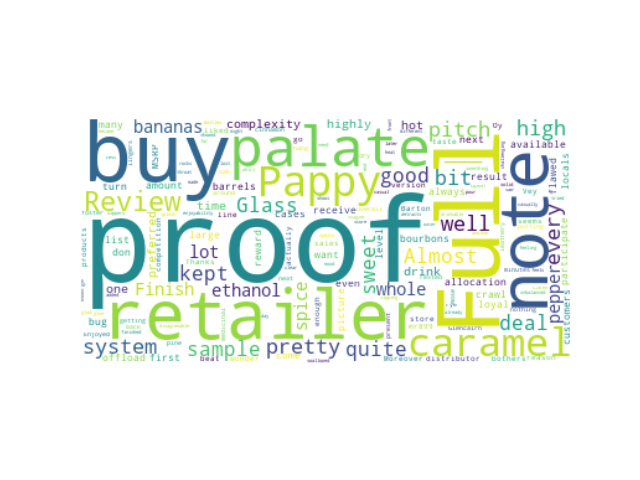

(-0.5, 399.5, 199.5, -0.5)

In [228]:
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [49]:
def continuef():
    continue

SyntaxError: 'continue' not properly in loop (<ipython-input-49-94ef01ca858b>, line 5)